In [1]:
from collections import Counter
import matplotlib.pyplot as plt
from pysankey2 import Sankey
from scipy.sparse import hstack, vstack, coo_matrix
from scipy.io import mmread
from sklearn import metrics
import math
import time
import anndata

import torch
import numpy as np
import scanpy as sc
import pandas as pd
import random
import os
from torch_geometric.data import Data
import pyHGT2
from pyHGT2.data import *
from pyHGT2.utils import *
from pyHGT2.model1 import *
from pyHGT2.conv import *
from sklearn import metrics
from warnings import filterwarnings
import scipy.sparse as sp
from operator import itemgetter
filterwarnings("ignore")
import json, os
import math, copy, time
import numpy as np
from collections import defaultdict

import pandas as pd
import math
from tqdm import tqdm
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import dill
from functools import partial
import multiprocessing as mp
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import SparsePCA
import torch.distributions as D
import torch.nn.functional as F
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import anndata as ad
seed = 0
# random.seed(seed)
torch.manual_seed(seed)
# np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# from transformers import *
random.seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
from scipy.sparse import hstack, vstack

# Result reading


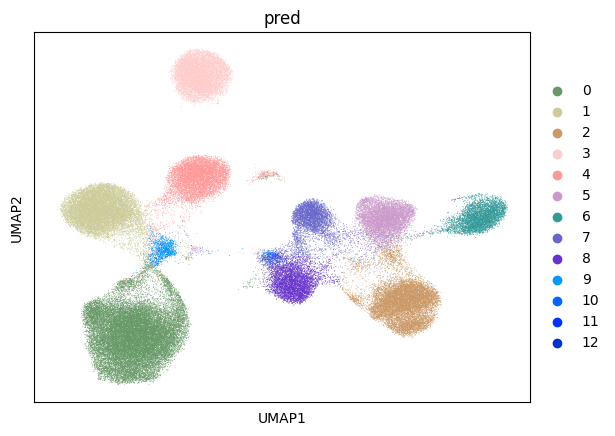

In [15]:
y = sc.read('/fs/ess/scratch/PCON0022/wxy/scDEAL/multi/case1/ycpu.h5ad')
#/users/PAS1475/anjunma/wxy/multi-HGT
sc.pp.neighbors(y, use_rep='pred_emb',n_neighbors=30)
#sc.tl.leiden(y,0.2)
sc.tl.umap(y)
y.uns['pred_colors'] = [ "#669966" ,"#CCCC99", "#CC9966", "#FFCCCC", "#FF9999", "#CC99CC", '#339999','#6666CC','#6633CC','#0099FF','#0066FF','#0033FF','#0033CC']
sc.pl.umap(y, color=['pred'])

# Dotplot

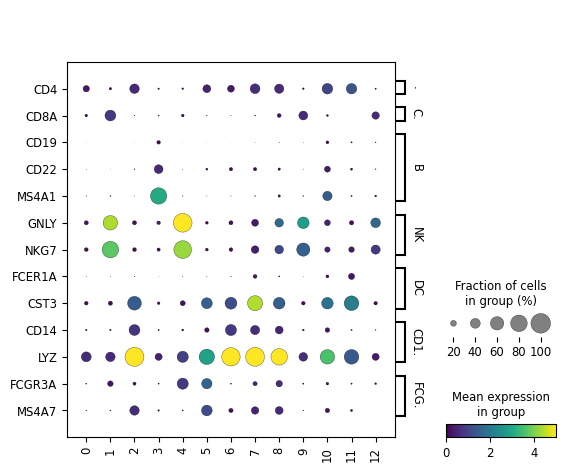

In [3]:
marker_gene_dict = {'CD4+T':['CD4'],'CD8+T':['CD8A'],'B':['CD19','CD22','MS4A1'],'NK':['GNLY','NKG7'],'DC':['FCER1A','CST3'],'CD14 Mono':['CD14','LYZ'],'FCGR3A Mono':['FCGR3A','MS4A7']}
sc.pl.dotplot(y,marker_gene_dict,groupby='pred',color_map='viridis',vmax=5,swap_axes=True,save='dotplot.svg')

# DEG function

In [4]:
def DEG(deg,NUM):
    NUM=NUM
    t12 = deg[[NUM+'_names',NUM+'_pvals_adj',NUM+'_logfoldchanges',NUM+'_pts']]
    t12 = t12[t12[NUM+'_logfoldchanges']>0.25]
    #t12 = deg[['12_names','12_pvals_adj','12_logfoldchanges','12_pts']]
    #t12 = t12[t12['12_logfoldchanges']>0.25]
    t12 = t12[t12[NUM+'_pvals_adj']<=0.05]
    t12 = t12[t12[NUM+'_pts']>0.1]
    #t12.sort_values(NUM+"_logfoldchanges",ascending=False)[0:9]
    gene0 = list(t12.sort_values(NUM+"_logfoldchanges",ascending=False)[NUM+'_names'])[0:10]
    return gene0

# The heatmap of DEGs in CD8 T (1,9,12) 

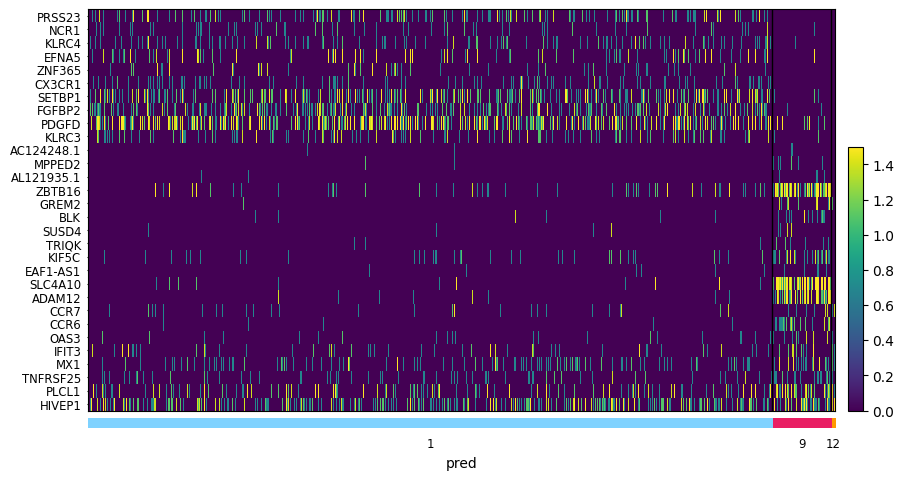

In [5]:
y_cd8=y[[True if i in [1,9,12] else False for i in y.obs['pred'] ]]
y_cd8.obs['pred'] = [str(i) for i in y_cd8.obs['pred']]
sc.pp.log1p(y_cd8)
sc.tl.rank_genes_groups(y_cd8, 'pred', method='wilcoxon',pts =True)
y_cd8.obs['pred'] = [int(i) for i in y_cd8.obs['pred']]
y_cd8.obs['pred'] =y_cd8.obs['pred'].astype('category')

#(y1, n_genes=3, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', figsize=(10,7), show=False);
result = y_cd8.uns['rank_genes_groups']
groups = result['names'].dtype.names
deg = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges','pts']})
gene1=DEG(deg,'1')
gene9=DEG(deg,'9')
gene12=DEG(deg,'12')
sc.pl.heatmap(y_cd8,gene1+gene9+gene12,groupby="pred",vmax=1.5, swap_axes=True)

# The heatmap of DEGs in DC

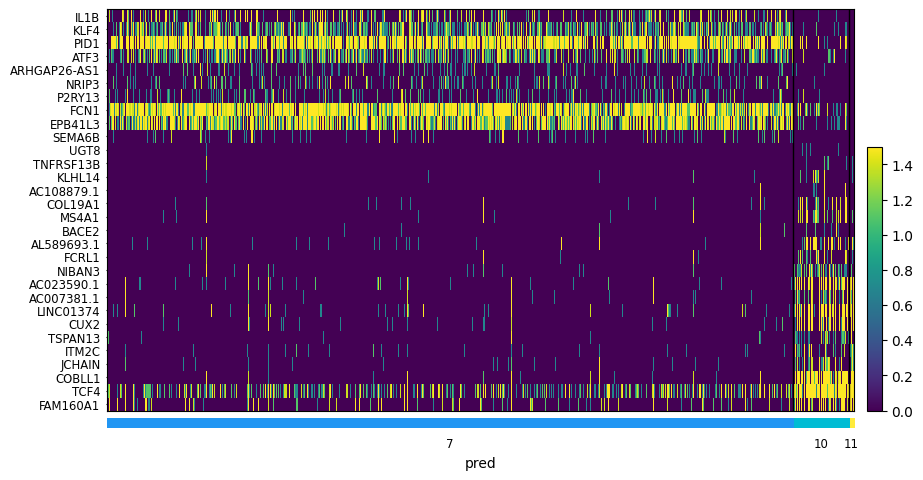

In [6]:
#y1=y
#sc.pp.log1p(y1)
#sc.tl.rank_genes_groups(y1, 'pred', method='wilcoxon',pts =True)
#y2=y[[True if i in ['1','9','12'] else False for i in y.obs['pred'] ]]
y2=y[[True if i in [7,10,11] else False for i in y.obs['pred'] ]]
y2.obs['pred'] = [str(i) for i in y2.obs['pred']]
sc.pp.log1p(y2)
sc.tl.rank_genes_groups(y2, 'pred', method='wilcoxon',pts =True)
y2.obs['pred'] = [int(i) for i in y2.obs['pred']]
y2.obs['pred'] =y2.obs['pred'].astype('category')

#(y1, n_genes=3, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', figsize=(10,7), show=False);
result = y2.uns['rank_genes_groups']
groups = result['names'].dtype.names
deg = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges','pts']})
gene7=DEG(deg,'7')
gene10=DEG(deg,'10')
gene11=DEG(deg,'11')
sc.pl.heatmap(y2,gene7+gene10+gene11,groupby="pred",vmax=1.5, swap_axes=True)

# The heatmap of DEGs in all clusters


         Falling back to preprocessing with `sc.pp.pca` and default params.


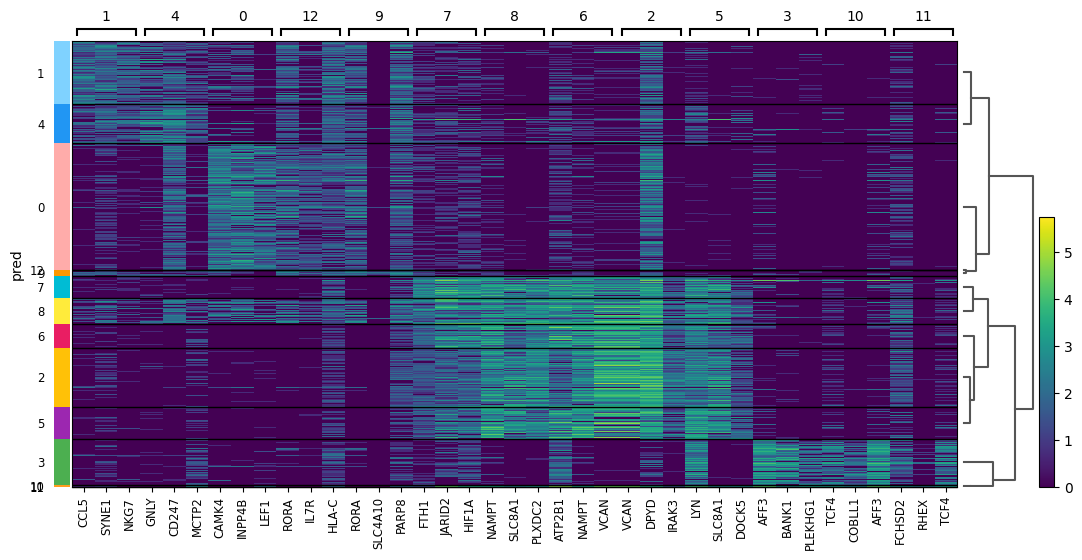

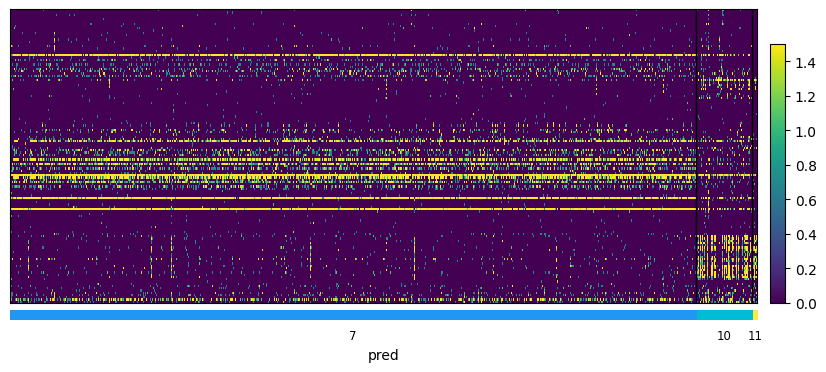

In [7]:
y1=y
sc.pp.log1p(y1)
sc.tl.rank_genes_groups(y1, 'pred', method='wilcoxon',pts =True)
y1.obs['pred'] = [str(i) for i in y1.obs['pred']]
y1.obs['pred'] =y1.obs['pred'].astype('category')
sc.pl.rank_genes_groups_heatmap(y1, n_genes=3)
#(y1, n_genes=3, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', figsize=(10,7), show=False);
result = y1.uns['rank_genes_groups']
groups = result['names'].dtype.names
deg = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges','pts']})
gene0=DEG(deg,'0')
gene1=DEG(deg,'1')
gene2=DEG(deg,'2')
gene3=DEG(deg,'3')
gene4=DEG(deg,'4')
gene5=DEG(deg,'5')
gene6=DEG(deg,'6')
gene7=DEG(deg,'7')
gene8=DEG(deg,'8')
gene9=DEG(deg,'9')
gene10=DEG(deg,'10')
gene11=DEG(deg,'11')
gene12=DEG(deg,'12')
gene = gene0+gene1+gene2+gene3+gene4+gene5+gene6+gene7+gene8+gene9+gene10+gene11+gene12
sc.pl.heatmap(y2,gene,groupby="pred",vmax=1.5, swap_axes=True)

# The UMAPs of MAIT markers 

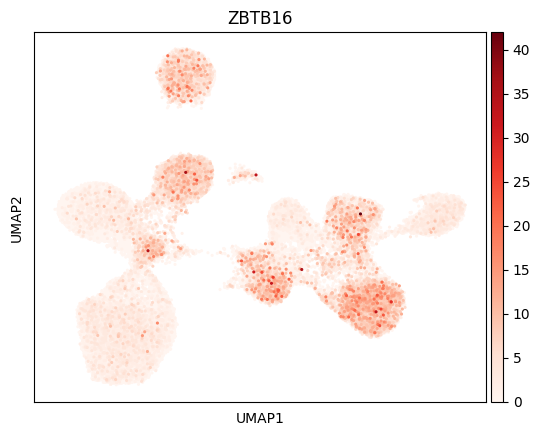

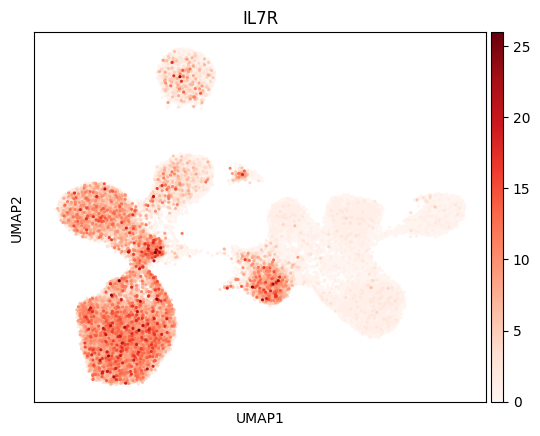

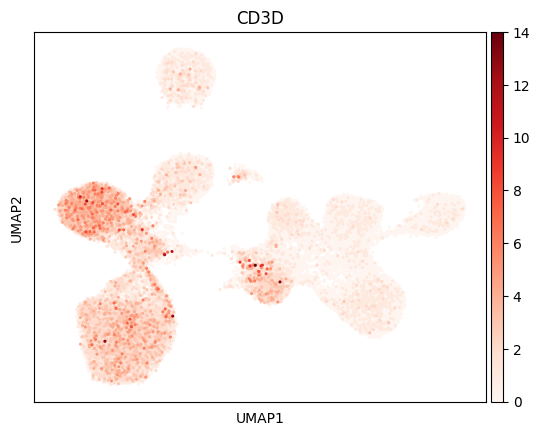

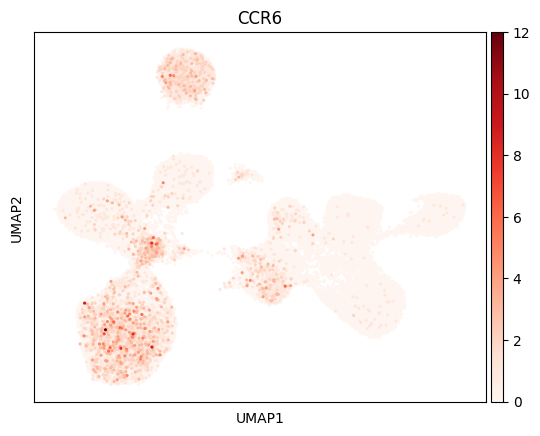

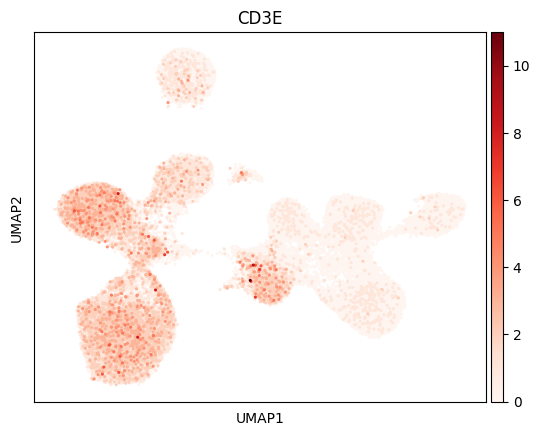

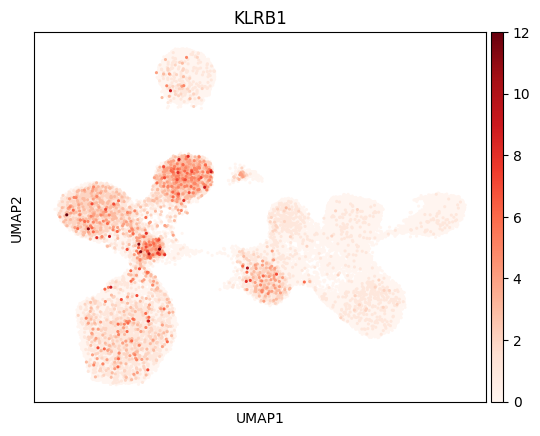

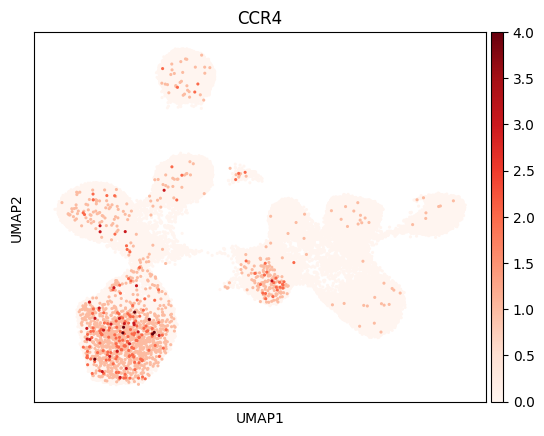

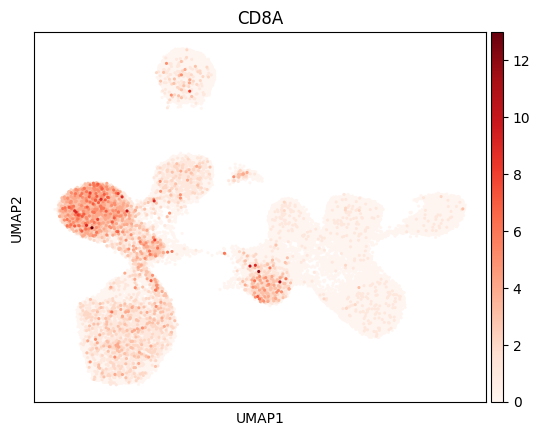

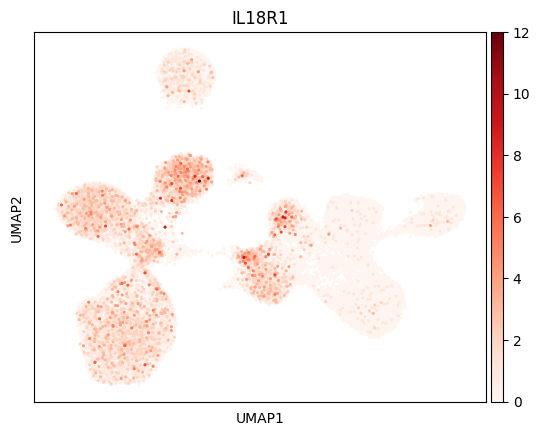

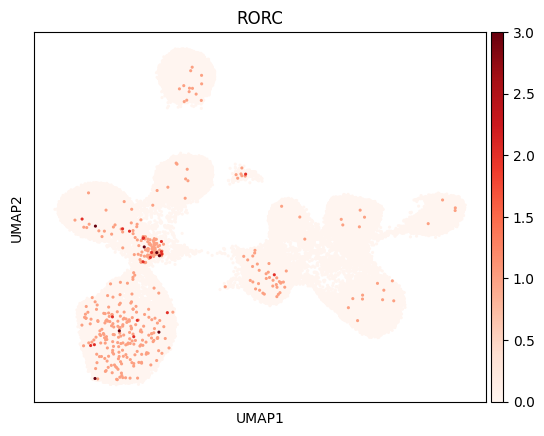

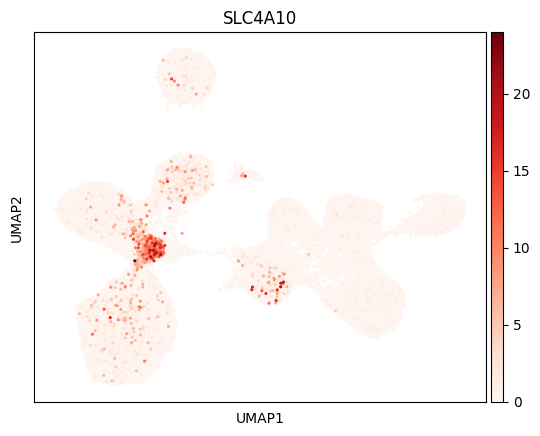

In [19]:
sc.pl.umap(y, color=['ZBTB16'], size=20,cmap='Reds',save="ZBTB16_umap.svg")
sc.pl.umap(y, color=['IL7R'], size=20,cmap='Reds',save="IL7R_umap.svg")
sc.pl.umap(y, color=['CD3D'], size=20,cmap='Reds',save="CD3D_umap.svg")
sc.pl.umap(y, color=['CCR6'], size=20,cmap='Reds',save="CCR6_umap.svg")
sc.pl.umap(y, color=['CD3E'], size=20,cmap='Reds',save="CD3E6_umap.svg")
sc.pl.umap(y, color=['KLRB1'], size=20,cmap='Reds',save="KLRB1_umap.svg")
sc.pl.umap(y, color=['CCR4'], size=20,cmap='Reds',save="CCR4_umap.svg") #negative
sc.pl.umap(y, color=['CD8A'], size=20,cmap='Reds',save="CD8A_umap.svg")
sc.pl.umap(y, color=['IL18R1'], size=20,cmap='Reds',save="IL18R1_umap.svg")
sc.pl.umap(y, color=['RORC'], size=20,cmap='Reds',save="RORC_umap.svg")
sc.pl.umap(y, color=['SLC4A10'], size=20,cmap='Reds',save="SLC4A10_umap.svg")

# The marker gene signature of NKT and MAIT

{'whiskers': [<matplotlib.lines.Line2D at 0x2b3454d6c850>,
 'caps': [<matplotlib.lines.Line2D at 0x2b33c74fd640>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b3454c52a90>,
 'medians': [<matplotlib.lines.Line2D at 0x2b33c7660af0>,
 'fliers': [<matplotlib.lines.Line2D at 0x2b3454d37b80>,
 'means': []}

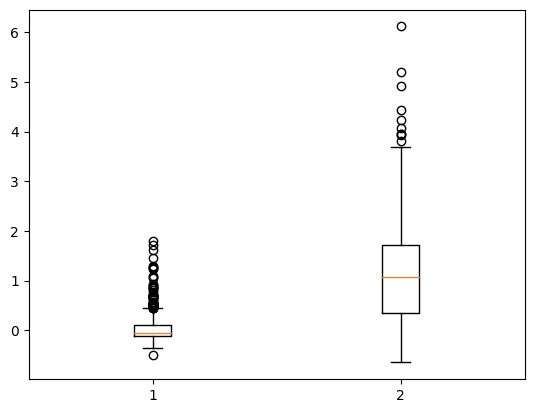

In [16]:
#c 
sc.tl.score_genes(y, ['SLAMF1', 'SLAMF6', 'FCGR3A','NCAM1','ITGA2'])
h = y[[True if i in [9,12] else False for i in y.obs['pred'] ]]
NKT = h.obs['score']
sc.tl.score_genes(y, ['CCR6', 'RORC', 'CD3D','CD8A','KLRB1','CD3E','ZBTB16','IL18R1','IL7R','SLC4A10'])
h = y[[True if i in [9,12] else False for i in y.obs['pred'] ]]
MAIT = h.obs['score']
plt.boxplot([NKT,MAIT])

# The pvalue calculation

In [18]:
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn
stat,p_value = scipy.stats.mannwhitneyu(NKT,
                                        MAIT,
                                     alternative='less')
#scipy.stats.wilcoxon( x, y,alternative = 'less')
p_value

6.29689800271664e-245

# MAIT efffect and exhausted

{'whiskers': [<matplotlib.lines.Line2D at 0x2b3454f4a8e0>,
 'caps': [<matplotlib.lines.Line2D at 0x2b3454b265b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b34554f2970>,
 'medians': [<matplotlib.lines.Line2D at 0x2b33c75fb370>,
 'fliers': [<matplotlib.lines.Line2D at 0x2b34556026d0>,
 'means': []}

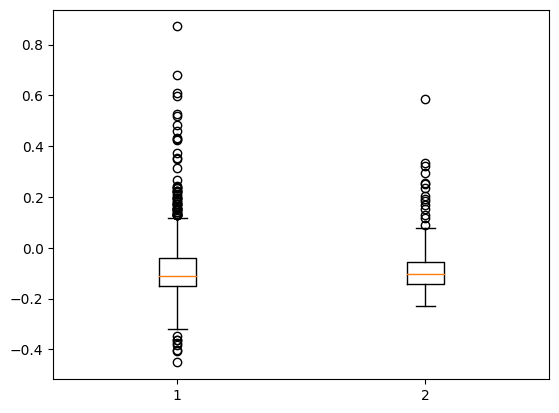

In [34]:
mk = ["low" if i in ["p5", "p6", "p7", "p8"] else i for i in y.obs['batch'] ]
mk = ["high" if i in ["p1", "p2", "p3", "p4"] else i for i in mk ]
mk = ["hd" if i in ["p9", "p10"] else i for i in mk ]
        
group_patient_cluster = [str(mk[i]) + "_" + str(y.obs['pred'][i]) for i in range(len(mk))]
y.obs['group_patient_cluster'] = group_patient_cluster
y.obs['group_patient_cluster'] = y.obs['group_patient_cluster'].astype('category')

#MAIT EFFECT
sc.tl.score_genes(y, ['KLRB1','GZMB','RORC','IL18R1','PRF1','IFNG','TBX21','EOMES','CTLA4'])
#MAIT exhausted
sc.tl.score_genes(y, ['HAVCR2', 'PDCD1', 'LAG3','TIGIT','CD160' ,'CD38','ENTPD1'])
y.obs['IRC'] = mk
y.obs['IRC'] = y.obs['IRC'].astype('category')
h = y[[True if i in [9] else False for i in y.obs['pred'] ]]
hh = h[[True if i in ['high','low'] else False for i in h.obs['IRC'] ]]
plt.boxplot([h[[True if i in ['low'] else False for i in h.obs['IRC']]].obs['score'],h[[True if i in ['high'] else False for i in h.obs['IRC']]].obs['score']])

# ZBTB16 related accessibility

In [22]:
import anndata as ad
import pandas as pd
sample='8'
gp = ad.read_mtx('/fs/ess/PCON0022/LiJingxian/Data/ATAC/mult/GSE199994/P'+sample+'/Gene_Peak.mtx')
gn = pd.read_csv('/fs/ess/PCON0022/LiJingxian/Data/ATAC/mult/GSE199994/P'+sample+"/Gene_names.tsv",header=None)[0]
pn = pd.read_csv('/fs/ess/PCON0022/LiJingxian/Data/ATAC/mult/GSE199994/P'+sample+"/Peak_names.tsv",header=None)[0]
gp.obs_names=gn
gp.var_names=pn
#expr = anndata.read_mtx('/users/PAS1475/anjunma/wxy/multi-HGT/case1/RNA/RNA'+sample+'.mtx')
acc = ad.read_mtx('/users/PAS1475/anjunma/wxy/multi-HGT/case1/ATAC/ATAC'+sample+'.mtx')
cellnames = pd.read_csv('/users/PAS1475/anjunma/wxy/multi-HGT/case1/ATAC/Cell_names'+sample+".csv")['x']
genenames = pd.read_csv('/users/PAS1475/anjunma/wxy/multi-HGT/case1/RNA/Gene_names'+sample+".csv")['x']
peaknames = pd.read_csv('/users/PAS1475/anjunma/wxy/multi-HGT/case1/ATAC/Peak_names'+sample+".csv")['x']
#expr.obs_names = gn
#expr.var_names = cellnames
acc.obs_names = pn
acc.var_names = cellnames


In [23]:
cell = y[[True if i in [9,12] else False for i in y.obs['pred'] ]].obs_names
y[[True if i in [9,12] else False for i in y.obs['pred'] ]]

View of AnnData object with n_obs × n_vars = 1209 × 14980
    obs: 'batch', 'leiden', 'pred', 'score'
    uns: 'neighbors', 'umap', 'pred_colors'
    obsm: 'X_umap', 'harmony', 'pred_emb'
    obsp: 'distances', 'connectivities'

In [24]:
p=["chr11:85752589-85753493",'chr1:198620935-198621840','chr19:54210656-54211490','chr14:71324553-71325443','chr2:101308300-101309196',"chr10:11162828-11163731","chr10:11178386-11179241","chr10:63268788-63269663",
"chr10:84333777-84334687","chr9:4938812-4939703","chr2:190881662-190882529","chr19:51372411-51373335","chr5:76402535-76403437"]
acc1 = acc.T[cell.intersection(cellnames),:]
acc1 = acc1[:,p]
acc1.obs['pred'] = y[cell.intersection(cellnames)].obs['pred']
peak_gene = ad.AnnData((np.hstack((acc1.X.todense(),np.array(np.mean(acc1[:,["chr10:11162828-11163731","chr10:11178386-11179241"]].X,1))))))
peak_gene.var_names=['SYTL2','PTPRC','RPS9','SIPA1L1','RNF149',"1","2",'JMJD1C','CCSER2','RCL1','GLS','NKG7','IQGAP2','CELF2']
#sc.pl.stacked_violin(acc1,list(set(a9+a12)), groupby='pred',vmax=10,cmap='Reds',save="MAITreg_peak.svg")

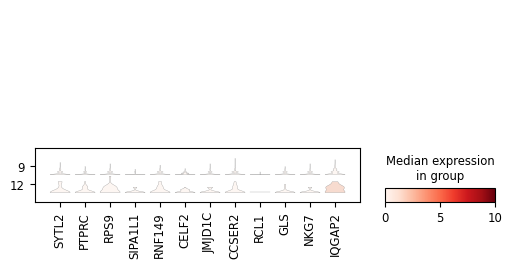

In [25]:
peak_gene.obs_names=cell.intersection(cellnames)
peak_gene.obs['pred'] = y[cell.intersection(cellnames)].obs['pred']
sc.pl.stacked_violin(peak_gene,['SYTL2','PTPRC','RPS9','SIPA1L1','RNF149','CELF2','JMJD1C','CCSER2','RCL1','GLS','NKG7','IQGAP2'], groupby='pred',vmax=10,cmap='Reds',save="MAITreg_peak.svg")

# eGRN inference

In [4]:

for sample in ['HD1','HD2']:
    gp = anndata.read_mtx('/fs/ess/PCON0022/LiJingxian/Data/ATAC/mult/GSE199994/'+sample+'/Gene_Peak.mtx')
    gn = pd.read_csv('/fs/ess/PCON0022/LiJingxian/Data/ATAC/mult/GSE199994/'+sample+"/Gene_names.tsv",header=None)[0]
    pn = pd.read_csv('/fs/ess/PCON0022/LiJingxian/Data/ATAC/mult/GSE199994/'+sample+"/Peak_names.tsv",header=None)[0]
    gp.obs_names=gn
    gp.var_names=pn
    expr = anndata.read_mtx('/users/PAS1475/anjunma/wxy/multi-HGT/case1/RNA/RNA'+sample+'.mtx')
    acc = anndata.read_mtx('/users/PAS1475/anjunma/wxy/multi-HGT/case1/ATAC/ATAC'+sample+'.mtx')
    cellnames = pd.read_csv('/users/PAS1475/anjunma/wxy/multi-HGT/case1/ATAC/Cell_names'+sample+".csv")['x']
    genenames = pd.read_csv('/users/PAS1475/anjunma/wxy/multi-HGT/case1/RNA/Gene_names'+sample+".csv")['x']
    peaknames = pd.read_csv('/users/PAS1475/anjunma/wxy/multi-HGT/case1/ATAC/Peak_names'+sample+".csv")['x']
    expr.obs_names = gn
    expr.var_names = cellnames
    acc.obs_names = pn
    acc.var_names = cellnames
    '''
    choice_cluser=1
    cell = y[[True if i in [choice_cluser] else False for i in y.obs['pred'] ]].obs_names
    pred_label = y[[True if i in [choice_cluser] else False for i in y.obs['pred'] ]].obs['pred']
    expr1 = expr[:,cell.intersection(cellnames)]
    acc1 = acc[:,cell.intersection(cellnames)]
    cell_emb_binary = sp.coo_matrix((np.ones(len(cell.intersection(cellnames))),(np.array(range(len(cell.intersection(cellnames)))),[0]*len(cell.intersection(cellnames)))))
    cell_emb_binary.todense()
    ATAC_matrix_ct = acc1.X*(cell_emb_binary)
    RNA_matrix_ct = expr1.X*(cell_emb_binary)
    RNA_matrix_ct = RNA_matrix_ct/np.sum(cell_emb_binary,axis=0)
    ATAC_matrix_ct = ATAC_matrix_ct/np.sum(cell_emb_binary,axis=0)

    m = range(RNA_matrix_ct.shape[0])
    gp1 = (gp.X).reshape(gp.shape[0]*gp.shape[1],1).todense()
    gene_emb_enh = ATAC_matrix_ct[list(range (ATAC_matrix_ct.shape[0]))*RNA_matrix_ct.shape[0]]
    peak_emb_enh = RNA_matrix_ct[[v for v in m for i in range(ATAC_matrix_ct.shape[0])]]
    egrn = np.multiply(gene_emb_enh, peak_emb_enh)
    egrn = np.multiply(egrn,gp1)
    data = np.array(np.squeeze(egrn))[0]
    gn1 = np.array(gn)[[v for v in m for i in range(ATAC_matrix_ct.shape[0])]]
    pn1 = np.array(pn)[list(range (ATAC_matrix_ct.shape[0]))*RNA_matrix_ct.shape[0]]
    gene_peak_score_Dict = {'gene': gn1, 'peak': pn1, 'score':data}
    gene_peak_score_df = pd.DataFrame(data = gene_peak_score_Dict)
    gene_peak_score = gene_peak_score_df[gene_peak_score_df['score'] > 0]
    gene_peak_score = gene_peak_score.drop_duplicates(['gene','peak'])
    gene_peak_score = gene_peak_score.sort_values('score', ascending=True)
    pd.DataFrame(gene_peak_score).to_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/1_s"+sample+"4_egrn.csv")
    '''
    choice_cluser=9
    cell = y[[True if i in [choice_cluser] else False for i in y.obs['pred'] ]].obs_names
    pred_label = y[[True if i in [choice_cluser] else False for i in y.obs['pred'] ]].obs['pred']
    expr1 = expr[:,cell.intersection(cellnames)]
    acc1 = acc[:,cell.intersection(cellnames)]
    cell_emb_binary = sp.coo_matrix((np.ones(len(cell.intersection(cellnames))),(np.array(range(len(cell.intersection(cellnames)))),[0]*len(cell.intersection(cellnames)))))
    cell_emb_binary.todense()
    ATAC_matrix_ct = acc1.X*(cell_emb_binary)
    RNA_matrix_ct = expr1.X*(cell_emb_binary)
    RNA_matrix_ct = RNA_matrix_ct/np.sum(cell_emb_binary,axis=0)
    ATAC_matrix_ct = ATAC_matrix_ct/np.sum(cell_emb_binary,axis=0)

    m = range(RNA_matrix_ct.shape[0])
    gp1 = (gp.X).reshape(gp.shape[0]*gp.shape[1],1).todense()
    gene_emb_enh = ATAC_matrix_ct[list(range (ATAC_matrix_ct.shape[0]))*RNA_matrix_ct.shape[0]]
    peak_emb_enh = RNA_matrix_ct[[v for v in m for i in range(ATAC_matrix_ct.shape[0])]]
    egrn = np.multiply(gene_emb_enh, peak_emb_enh)
    egrn = np.multiply(egrn,gp1)
    data = np.array(np.squeeze(egrn))[0]
    gn1 = np.array(gn)[[v for v in m for i in range(ATAC_matrix_ct.shape[0])]]
    pn1 = np.array(pn)[list(range (ATAC_matrix_ct.shape[0]))*RNA_matrix_ct.shape[0]]
    gene_peak_score_Dict = {'gene': gn1, 'peak': pn1, 'score':data}
    gene_peak_score_df = pd.DataFrame(data = gene_peak_score_Dict)
    gene_peak_score = gene_peak_score_df[gene_peak_score_df['score'] > 0]
    gene_peak_score = gene_peak_score.drop_duplicates(['gene','peak'])
    gene_peak_score = gene_peak_score.sort_values('score', ascending=True)
    pd.DataFrame(gene_peak_score).to_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/9_s"+sample+"_egrn.csv")
    choice_cluser=12
    cell = y[[True if i in [choice_cluser] else False for i in y.obs['pred'] ]].obs_names
    pred_label = y[[True if i in [choice_cluser] else False for i in y.obs['pred'] ]].obs['pred']
    expr1 = expr[:,cell.intersection(cellnames)]
    acc1 = acc[:,cell.intersection(cellnames)]
    cell_emb_binary = sp.coo_matrix((np.ones(len(cell.intersection(cellnames))),(np.array(range(len(cell.intersection(cellnames)))),[0]*len(cell.intersection(cellnames)))))
    cell_emb_binary.todense()
    ATAC_matrix_ct = acc1.X*(cell_emb_binary)
    RNA_matrix_ct = expr1.X*(cell_emb_binary)
    RNA_matrix_ct = RNA_matrix_ct/np.sum(cell_emb_binary,axis=0)
    ATAC_matrix_ct = ATAC_matrix_ct/np.sum(cell_emb_binary,axis=0)

    m = range(RNA_matrix_ct.shape[0])
    gp1 = (gp.X).reshape(gp.shape[0]*gp.shape[1],1).todense()
    gene_emb_enh = ATAC_matrix_ct[list(range (ATAC_matrix_ct.shape[0]))*RNA_matrix_ct.shape[0]]
    peak_emb_enh = RNA_matrix_ct[[v for v in m for i in range(ATAC_matrix_ct.shape[0])]]
    egrn = np.multiply(gene_emb_enh, peak_emb_enh)
    egrn = np.multiply(egrn,gp1)
    data = np.array(np.squeeze(egrn))[0]
    gn1 = np.array(gn)[[v for v in m for i in range(ATAC_matrix_ct.shape[0])]]
    pn1 = np.array(pn)[list(range (ATAC_matrix_ct.shape[0]))*RNA_matrix_ct.shape[0]]
    gene_peak_score_Dict = {'gene': gn1, 'peak': pn1, 'score':data}
    gene_peak_score_df = pd.DataFrame(data = gene_peak_score_Dict)
    gene_peak_score = gene_peak_score_df[gene_peak_score_df['score'] > 0]
    gene_peak_score = gene_peak_score.drop_duplicates(['gene','peak'])
    gene_peak_score = gene_peak_score.sort_values('score', ascending=True)
    pd.DataFrame(gene_peak_score).to_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/12_s"+sample+"_egrn.csv")


FileNotFoundError: [Errno 2] No such file or directory: '/users/PAS1475/anjunma/wxy/multi-HGT/case1/RNA/RNAHD1.mtx'

In [18]:
gene_peak_score_df = pd.DataFrame(data = gene_peak_score_Dict)
gene_peak_score = gene_peak_score_df[gene_peak_score_df['score'] > 0]
gene_peak_score = gene_peak_score.drop_duplicates(['gene','peak'])
gene_peak_score = gene_peak_score.sort_values('score', ascending=True)


In [28]:
gene_peak_score

,gene,peak,score
1485214966,SCGB1C2,chr17:286309-286826,1.503433e-11
14287011,ACOD1,chr13:76799352-76800260,1.534545e-11
130551949,BANCR,chr9:69158017-69158870,1.544308e-11
212645131,CATSPER3,chr5:135115915-135116683,1.567984e-11
1044190466,MIR4290HG,chr9:90189047-90189932,1.612345e-11
...,...,...,...
1017649016,MCM3,chr6:52397749-52398628,9.479143e+00
1340324816,PREX1,chr20:48904749-48905656,1.071064e+01
1340324818,PREX1,chr20:48910162-48911074,1.208999e+01
1017649018,MCM3,chr6:52416292-52417192,2.110725e+01


In [21]:
pd.DataFrame(gene_peak_score).to_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/9_s1_egrn.csv")

In [ ]:
pred_label = h.obs['pred']
yy = ad.AnnData(RNA_matrix.transpose(), dtype='int32')
#cluster 1
#choice_cluser=1
#cluster 9
choice_cluser=9   
#cluster 12
#choice_cluser=12
#y.var_names=gene_names[0]
#y.var_names=gene_names
yy.var_names = Geak_Peak.var_names
yy.obs['pred'] = np.array(pred_label)
yy.obs['pred'] = y.obs['pred'].astype("category")
## 把预测结果存储为稀疏矩阵，行代表细胞，列代表聚类标签 对应位置为1表示该细胞属于该类
cell_emb_binary = sp.coo_matrix((np.ones(len(pred_label)),(np.array(range(len(pred_label))),[0]*len(pred_label))))
cell_emb_binary.todense()

#adata_atac_all = ATAC_matrix[:,nodes_id]
#adata_rna_all = RNA_matrix[:,nodes_id]
adata_atac_all1 = ATAC_matrix
adata_rna_all1 = RNA_matrix

ATAC_matrix_ct = adata_atac_all1*(cell_emb_binary)
RNA_matrix_ct = adata_rna_all1*(cell_emb_binary)

In [10]:
from upsetplot import generate_counts
from upsetplot import from_contents
plt.figure()
contents = {
    "CD8+ T": list(set(g1)),  # set1 包含 a、b、c 三个对象
    "MAIT-like 1": list(set(g9)),       # set2 包含 b、d 两个对象
    "MAIT-like 2": list(set(g12))
}

from upsetplot import plot
plot(from_contents(contents),show_counts='%d')
#plt.savefig("/fs/ess/scratch/PCON0022/wxy/scDEAL/multi/case1_sub/upset_g.svg")

NameError: name 'y' is not defined

In [15]:
b=list()
for sample in ['1','2','3','4','5','6','7','8']:
    a = pd.read_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/9_s"+sample+"_egrn.csv")
    a = a['gene'][(a['score']>0.1)&([not(i[0:3]=='MT-') for i in a['gene']])]
    b = b+list(a)
gene9 = set(b)
b=list()
for sample in ['1','2','3','4','5','6','7','8']:
    a = pd.read_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/1_s"+sample+"_egrn.csv")
    a = a['gene'][(a['score']>0.1)&([not(i[0:3]=='MT-') for i in a['gene']])]
    b = b+list(a)
gene1 = set(b)
b=list()
for sample in ['2','3','4','5','6','7','8']:
    a = pd.read_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/12_s"+sample+"_egrn.csv")
    a = a['gene'][(a['score']>0.1)&([not(i[0:3]=='MT-') for i in a['gene']])]
    b = b+list(a)
gene12 = set(b)

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

<Figure size 640x480 with 0 Axes>

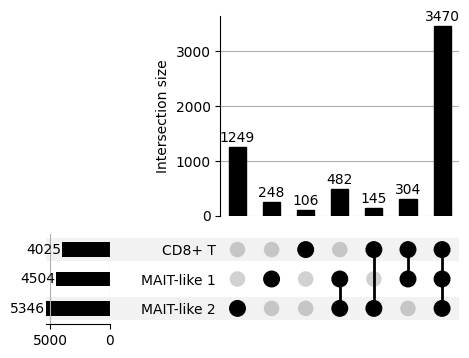

In [24]:
from upsetplot import generate_counts
from upsetplot import from_contents
plt.figure()
contents = {
    "CD8+ T": list(set(gene1)),  # set1 包含 a、b、c 三个对象
    "MAIT-like 1": list(set(gene9)),       # set2 包含 b、d 两个对象
    "MAIT-like 2": list(set(gene12))
}

from upsetplot import plot
plot(from_contents(contents),show_counts='%d')

In [30]:
b=list()
for sample in ['1','2','3','4','5','6','7','8']:
    a = pd.read_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/9_s"+sample+"_egrn.csv")
    a = a['peak'][(a['score']>0.1)&([not(i[0:3]=='MT-') for i in a['gene']])]
    b = b+list(a)
peak9 = set(b)
b=list()
for sample in ['1','2','3','4','5','6','7','8']:
    a = pd.read_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/1_s"+sample+"_egrn.csv")
    a = a['peak'][(a['score']>0.1)&([not(i[0:3]=='MT-') for i in a['gene']])]
    b = b+list(a)
peak1 = set(b)
b=list()
for sample in ['2','3','4','5','6','7','8']:
    a = pd.read_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/12_s"+sample+"_egrn.csv")
    a = a['peak'][(a['score']>0.1)&([not(i[0:3]=='MT-') for i in a['gene']])]
    b = b+list(a)
peak12 = set(b)

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

<Figure size 640x480 with 0 Axes>

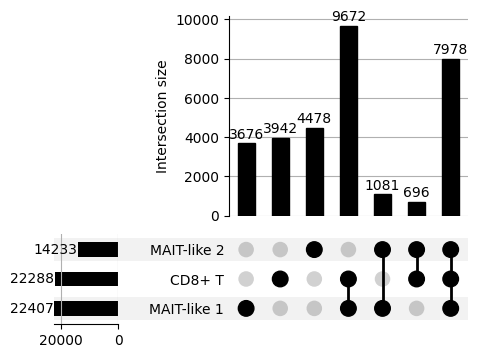

In [31]:
from upsetplot import generate_counts
from upsetplot import from_contents
plt.figure()
contents = {
    "CD8+ T": list(set(peak1)),  # set1 包含 a、b、c 三个对象
    "MAIT-like 1": list(set(peak9)),       # set2 包含 b、d 两个对象
    "MAIT-like 2": list(set(peak12))
}

from upsetplot import plot
plot(from_contents(contents),show_counts='%d')

In [33]:
#a = pd.read_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/12_s"+sample+"_egrn.csv")
a[(a['score']>0.1)&([not(i[0:3]=='MT-') for i in a['gene']])]

,Unnamed: 0,gene,peak,score
45430,803267592,HDGFL2,chr19:4471488-4472400,0.100029
45431,110365238,ARHGEF18,chr19:7349929-7350679,0.100049
45432,2305192205,XPO6,chr16:28217832-28218723,0.100071
45433,880036774,IL7R,chr5:35816836-35817729,0.100189
45434,806707692,HELZ,chr17:67258640-67259521,0.100268
...,...,...,...,...
50414,1236652070,MALAT1,chr11:65497156-65498036,158.409220
50415,1747854852,RCL1,chr9:4971073-4971978,370.131406
50416,14569638,ACAP1,chr17:7455198-7455981,460.563516
50417,14569639,ACAP1,chr17:7456114-7456733,569.301353


In [34]:
a = pd.read_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/12_s"+'2'+"_egrn.csv")
for sample in ['3','4','5','6','7','8']:
    a = pd.read_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/12_s"+sample+"_egrn.csv")
    b = a[(a['score']>0.1)&([not(i[0:3]=='MT-') for i in a['gene']])]
    df = pd.concat([a])

In [36]:
df.to_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/12_total_egrn.csv")

In [37]:
a = pd.read_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/9_s"+'1'+"_egrn.csv")
for sample in ['2','3','4','5','6','7','8']:
    a = pd.read_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/9_s"+sample+"_egrn.csv")
    b = a[(a['score']>0.1)&([not(i[0:3]=='MT-') for i in a['gene']])]
    df = pd.concat([a])
df.to_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/9_total_egrn.csv")

In [38]:
a = pd.read_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/1_s"+'1'+"_egrn.csv")
for sample in ['2','3','4','5','6','7','8']:
    a = pd.read_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/1_s"+sample+"_egrn.csv")
    b = a[(a['score']>0.1)&([not(i[0:3]=='MT-') for i in a['gene']])]
    df = pd.concat([a])
df.to_csv("/users/PAS1475/anjunma/wxy/multi-HGT/case1/1_total_egrn.csv")